In [47]:
import torch
import torch.nn as nn
import pickle
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
plt.style.use("ggplot")


from stabnode.node import MLP

device = "cpu"

In [2]:
log_path = "decay_1/log_hist.pkl"

In [3]:
with open(log_path, 'rb') as file:
    log = pickle.load(file)

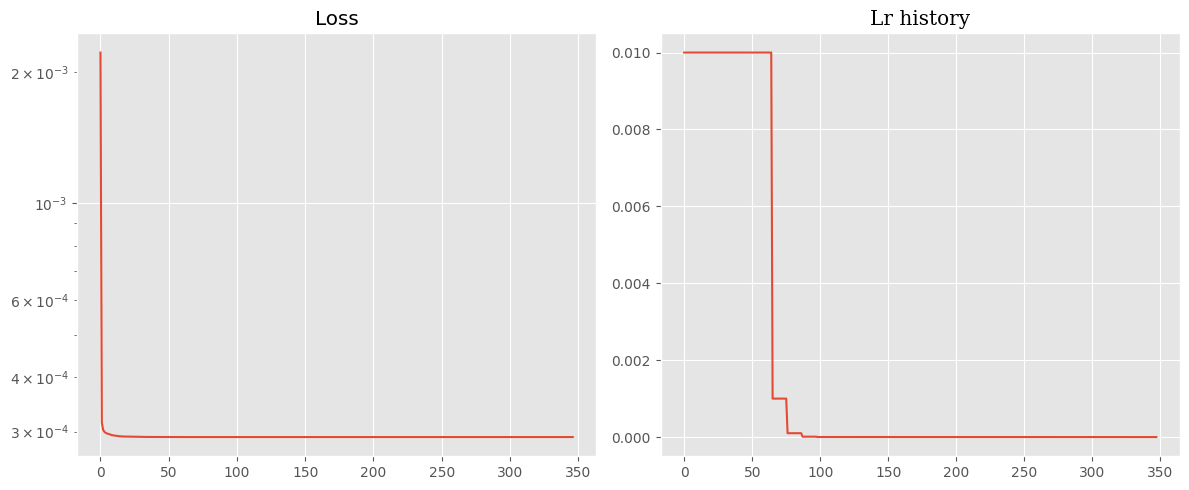

In [59]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(log["losses"][:-1])
ax1.set_yscale("log")
ax1.set_title("Loss")

ax2.plot(log["lr_hist"])
ax2.set_title("Lr history", family='serif')
plt.tight_layout()
plt.show()

In [18]:
model_path = "decay_1/model_opt_states.pt"
config = torch.load(model_path)

In [20]:
config["model_args"]

{'dims': [2, 10, 10, 1],
 'activation': torch.nn.modules.activation.SiLU,
 'lower_bound': 0,
 'upper_bound': 1,
 'dtype': torch.float32}

In [23]:
class ODEFunc(nn.Module):
    def __init__(
        self,
        dims,          
        activation=nn.SiLU(),
        lower_bound=-1.0,
        upper_bound=1.0,
        dtype=torch.float
    ):
        super().__init__()
        self.dims = dims
        self.activation = activation
        self.dtype = dtype

        self.network = MLP(self.dims, activation=self.activation, dtype=self.dtype)

        self.args = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
        }

    def forward(self,x,k):
        """
        state = (x, k)
        x : [batch, dim_x]
        k : [batch, dim_k]
        """
        # x, k 
        a = self.args["lower_bound"]
        b = self.args["upper_bound"]

        xk = torch.cat([x, k], dim=-1)                 
        dxdt = a + (b - a) * torch.sigmoid(self.network(xk))  

        return dxdt

In [25]:
model = ODEFunc(
    dims=[2,10,10,1],
    activation=nn.SiLU(),
    lower_bound=0,
    upper_bound=1
).to(device)

In [37]:
model.load_state_dict(config["model_state_dict"])
model_eval = model.eval()

## Load data

In [34]:
from sklearn.preprocessing import MinMaxScaler
from data.budworm import simulate_trials
import pandas as pd

In [35]:
from typing import List
class TrialsDataset(torch.utils.data.Dataset):
    def __init__(self, x_trials: List, t_trials: List, k_trials: List):
        self.x_trials = x_trials
        self.t_trials = t_trials
        self.k_trials = k_trials

    def __len__(self):
        return len(self.x_trials)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self):
            raise IndexError(
                f"Index {idx} is out of bounds of dataset size: {len(self)}."
            )

        Xi = self.x_trials[idx]
        ti = self.t_trials[idx]
        x0 = Xi[0]
        ki = self.k_trials[idx]

        return Xi, ti, x0, ki

In [36]:
# Simulation parameters
k_vals = [5.5, 6.3, 7.5, 8.5, 11.0]  # carrying capacities
xs = np.linspace(0.1, 10, 51)

# -----------------------------------------------------------------
# DATA GENERATION
# -----------------------------------------------------------------
trials = {}
for idx, ki in enumerate(k_vals):
    ki_traj, ki_times = [], []

    for x0 in xs:
        trial = simulate_trials(
            [ki],
            x0,
            dt=0.2,
            r=0.56,
            eps=1e-3,
            buffer=1e-1,
            t_max=400,
            n_points=501,
            show_progress=False,
        )
        if len(trial.t_vals[0]) == 1:
            continue
        ki_traj.append(trial.x_vals[0])
        ki_times.append(trial.t_vals[0])

    trials[str(idx)] = {
        "traj": ki_traj,
        "times": ki_times,
        "k": ki,
        "trial": idx,
    }

trial_df = pd.DataFrame(trials)

# -----------------------------------------------------------------
# SCALING
# -----------------------------------------------------------------
full_traj = [np.concatenate(trial_df[col].traj) for col in trial_df.columns]
scaler = MinMaxScaler()
scaler.fit(np.concatenate(full_traj).reshape(-1, 1))

scaled_rows = {}
for col in trial_df.columns:
    traj = trial_df[col].traj
    scaled_rows[col] = [
        scaler.transform(xi.reshape(-1, 1)).reshape(-1) for xi in traj
    ]
trial_df.loc["scaled_traj"] = pd.Series(scaled_rows)

# -----------------------------------------------------------------
# TORCH DATASET PREP
# -----------------------------------------------------------------
all_xs, all_ts, all_ks = [], [], []

for trial_i in trial_df.columns:
    xs_scaled = trial_df[trial_i].scaled_traj
    ts = trial_df[trial_i].times
    k = trial_df[trial_i].k

    xs_torch = [
        torch.tensor(xi, dtype=torch.float32, device=device) for xi in xs_scaled
    ]
    ts_torch = [
        torch.tensor(ti, dtype=torch.float32, device=device) for ti in ts
    ]
    ks = [torch.tensor(k, dtype=torch.float32, device=device) for _ in ts]

    all_xs.extend(xs_torch)
    all_ts.extend(ts_torch)
    all_ks.extend(ks)

train_dataset = TrialsDataset(all_xs, all_ts, all_ks)

In [43]:
indices = [0]
for key, val in trials.items():
    print(val["k"], len(val["traj"]))
    indices.append(len(val["traj"]))
indices = np.cumsum(indices)

5.5 51
6.3 51
7.5 50
8.5 51
11.0 51


## Look at learned trajectories

In [40]:
from torchode import solve_ivp
from data.budworm import budworm_steady_states

In [44]:
indices

array([  0,  51, 102, 152, 203, 254])

  0%|          | 0/51 [00:00<?, ?it/s]

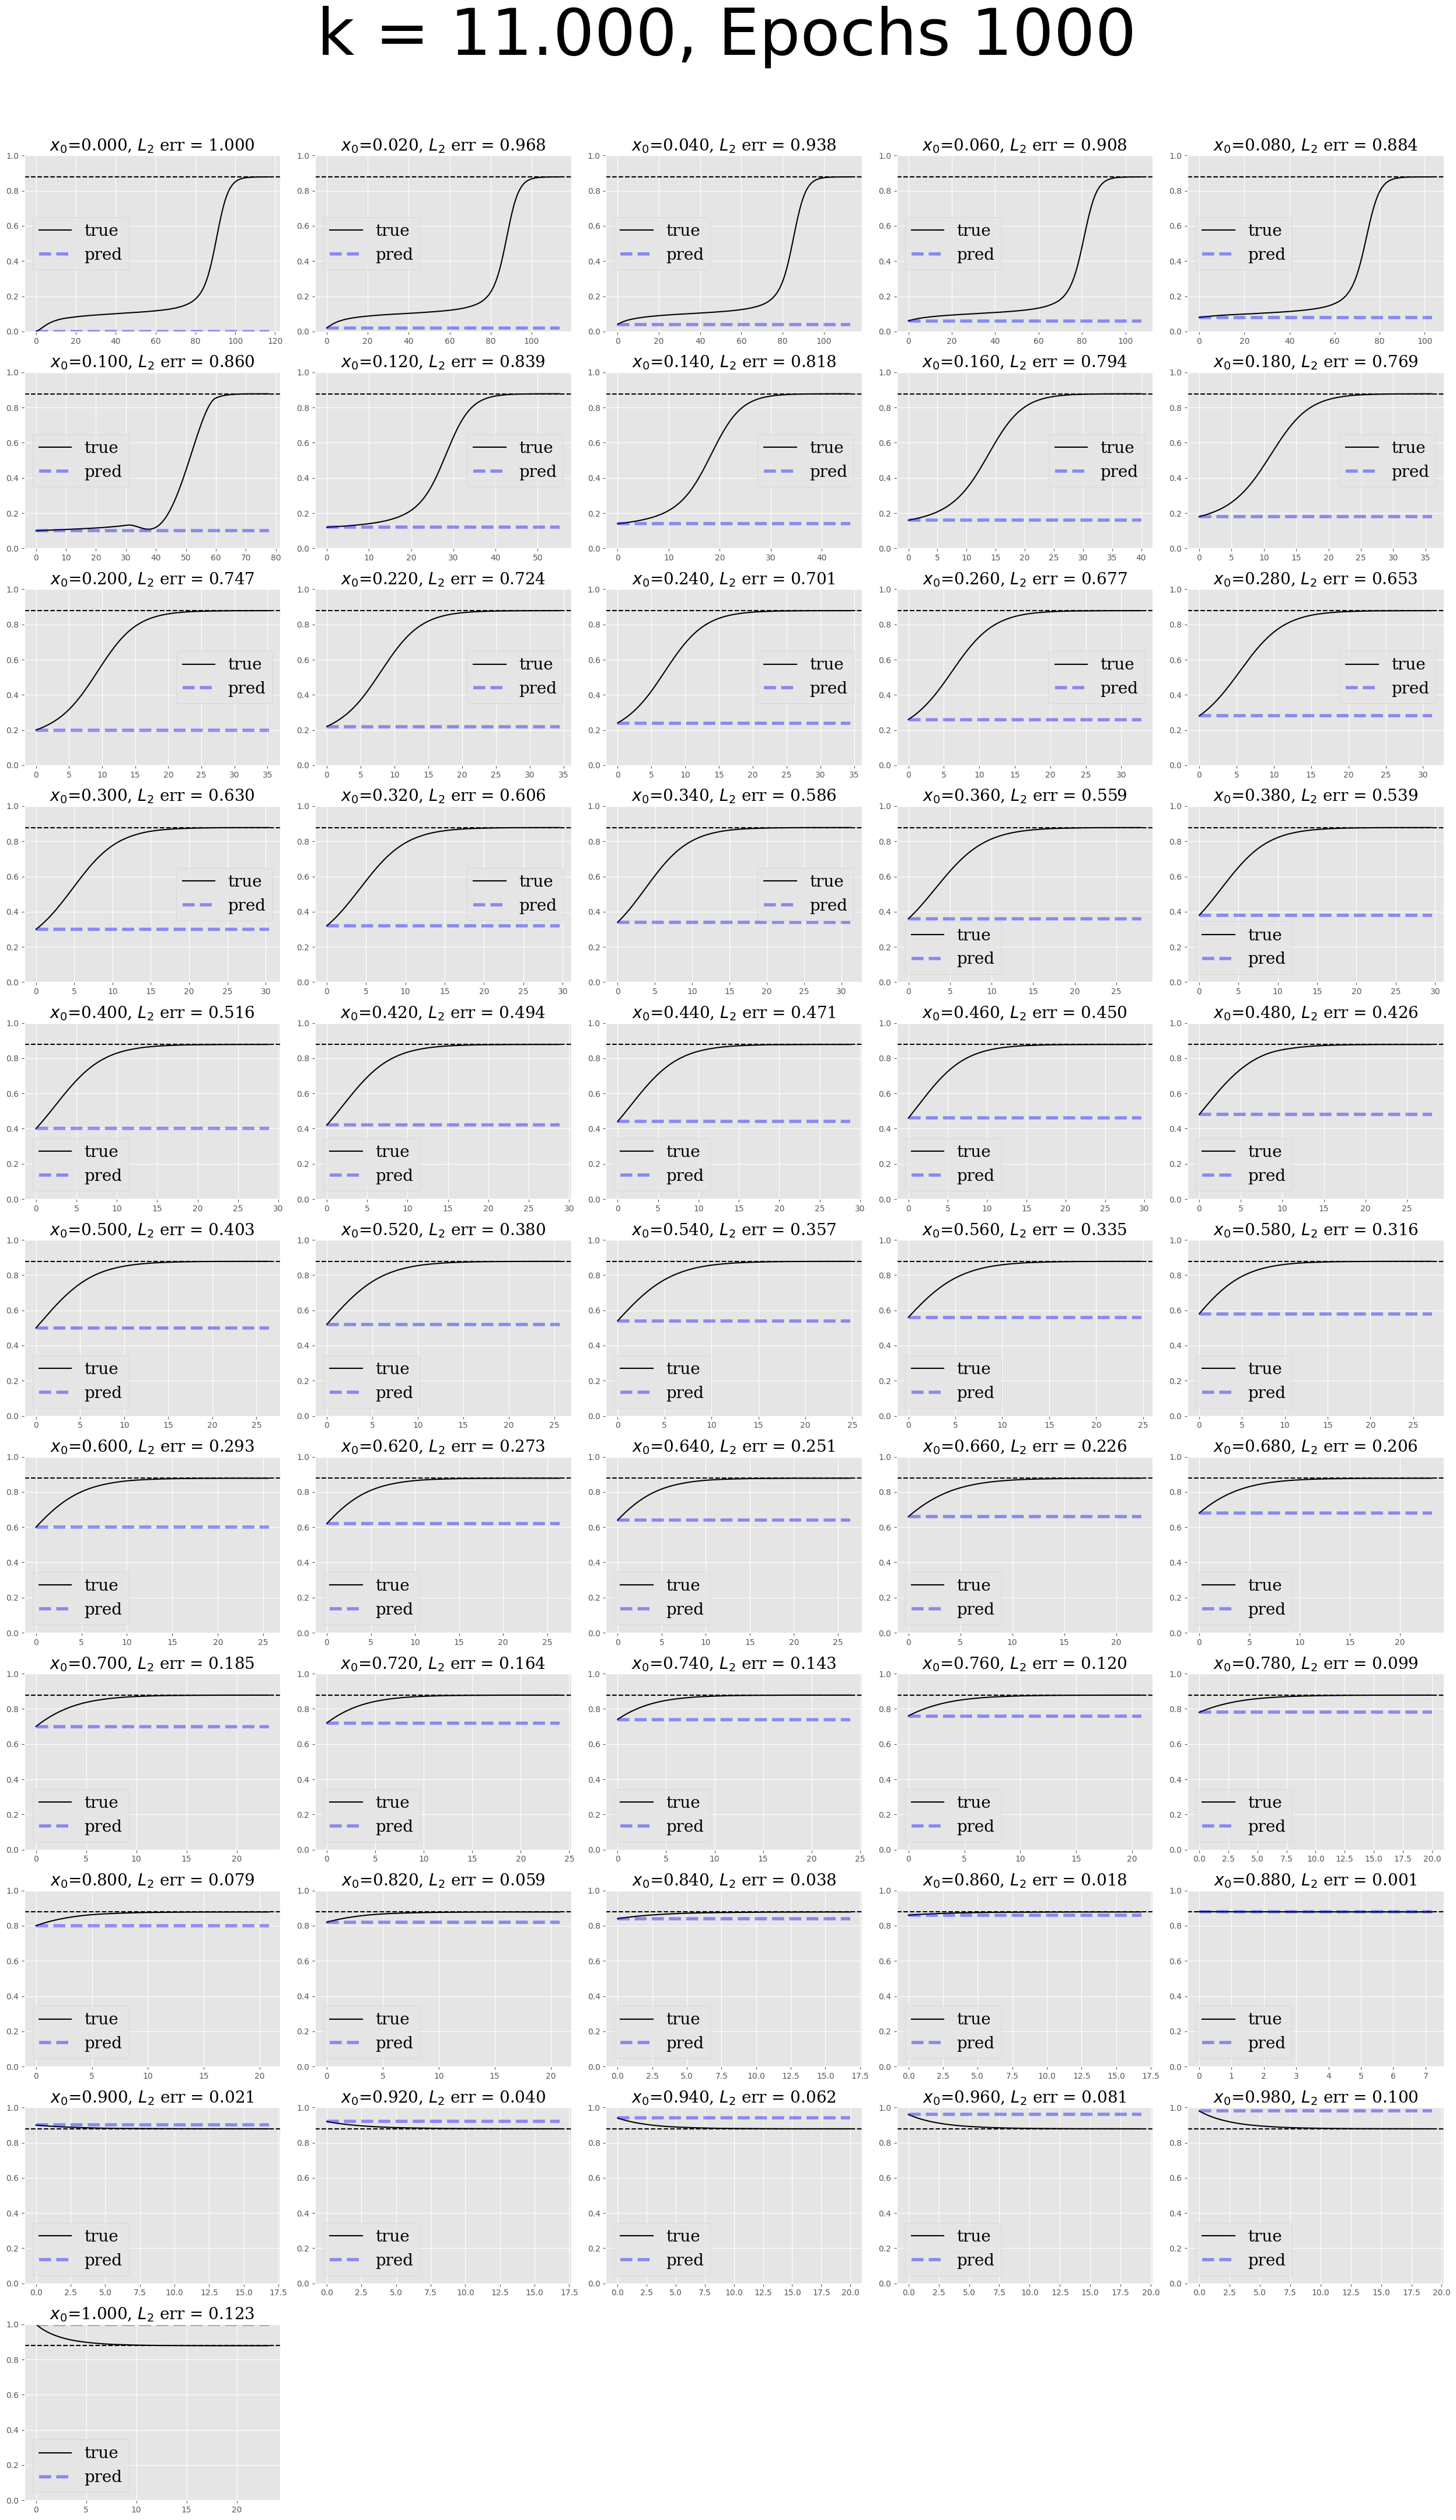

In [55]:
i=4
cols = 5
rows = int(np.ceil(len(range(indices[i], indices[i+1]))/cols))

fig, axs = plt.subplots(rows, cols,figsize=(5*cols,4*rows))

axs = axs.flatten()
k_val = None
# control_func = lambda t: torch.tensor(k,dtype=torch.float32,device=device).unsqueeze(0)
with torch.no_grad():
    for idx in tqdm(range(indices[i], indices[i+1])):
        ax = axs[idx - indices[i]]
        xi, ti, x0i,ki = train_dataset[idx]
        xi = xi.squeeze() # [batch, time, dim]
        ti = ti.squeeze()
        k_val = ki
        ki = ki.view(1)
        x0i = x0i.view(-1,1)

        # print(xi.shape, ti.shape)

        control_func = lambda t: ki

        def rhs(t,x):
            return model_eval(x,ki.view(-1,1))
        
        sol = solve_ivp(
            f=rhs,
            y0=x0i,
            t_eval=ti,
            method="tsit5"
        )

        rel_l2_err = np.linalg.norm(sol.ys.squeeze() - xi)/np.linalg.norm(xi)

        ax.plot(ti,xi,label='true',color='black')
        ax.plot(sol.ts.squeeze(),sol.ys.squeeze(),label="pred", linestyle='--', color='blue',alpha=0.4,lw=4)
        ax.set_ylim(0,1)
        ax.set_title(rf"$x_0$={x0i.squeeze().cpu().numpy():.3f}, $L_2$ err = {rel_l2_err:.3f}", family='serif',size=20)
        ax.legend(prop={'family':'serif','size':20})

        scaled_steady_states = scaler.transform(np.array(budworm_steady_states(ki.squeeze(),r=0.56)).reshape(-1,1)).reshape(-1)
        for idx,xsi in enumerate(scaled_steady_states):
            label = rf"steady state. $x_s=${xsi:.3f}"
            color = 'black'
            if idx ==1:
                label = rf"unsteady state. $x_s=${xsi:.3f}"
                color = 'red'

            ax.axhline(
                xsi,
                xmin=0,
                c=color,
                linestyle="--",
                label=label,
                zorder=2
            )

    for idx in range(len(range(indices[i], indices[i+1])), rows*cols):
        fig.delaxes(axs[idx])

plt.suptitle(f"k = {k_val.squeeze().numpy():.3f}, Epochs {1000}", size=80)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()
